<a href="https://colab.research.google.com/github/Gops03/TEORIA_DE_SE-ALES/blob/main/Red_triple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#LIBRERIAS
import numpy as np
from scipy.signal import welch
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, ifft
import pandas as pd
from scipy.signal import welch, find_peaks
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
# Configurar el estilo general de las gráficas
plt.style.use('seaborn-darkgrid')

#FUNCIONES ESTRUCTURA DE LAS REDES
# Definir la métrica R² personalizada
def r2_keras(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res / (SS_tot + K.epsilon()))

#DEFINICION DE LOS MODELOS
def Modelos(n, X, y):
  # Dividir los datos en conjuntos de entrenamiento y prueba
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  if n == 1:
    # Definir el modelo (MLP)
    model = Sequential([
        Dense(512, activation='relu', kernel_regularizer=l2(0.002), input_shape=(X_train.shape[1],)),
        Dropout(0.4),
        Dense(256, activation='relu', kernel_regularizer=l2(0.002)),
        Dropout(0.4),
        Dense(128, activation='relu', kernel_regularizer=l2(0.002)),
        Dense(y_train.shape[1], activation='linear')
    ])
  elif n == 2:
    # Definir el modelo (LSTM)
    model = Sequential([
        LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.4),
        LSTM(64, activation='relu', return_sequences=False),
        Dropout(0.4),
        Dense(128, activation='relu', kernel_regularizer=l2(0.002)),
        Dense(y_train.shape[1], activation='linear')
    ])

  return model

#FUNCION DE GENERACION DE SEÑAL
def señal_generada(fs, f1, f2, f3, A1, A2, A3, t):
  wo = 2*np.pi
  t=t
  # Crear la señal base x(t)
  signal = A1 * np.cos(wo * f1 * t) + A2 * np.sin(wo * f2 * t) + A3 * np.cos(wo * f3 * t)
  return signal

#GENERACION DE VECTORES X y Y PARA LA RED NEURONAL
def datos(signal):
      # Generar un conjunto de datos sintéticos con diferentes niveles de ruido
    num_samples = 1000
    X = []
    y = []

    for _ in range(num_samples):
        # Añadir ruido blanco gaussiano con nivel de sigma
        noise = np.random.normal(0, sigma, signal.shape)
        noisy_signal = signal + noise

        # Almacenar la señal ruidosa
        X.append(noisy_signal)

        # Calcular la PSD usando Welch
        f, Pxx = welch(noisy_signal, fs, nperseg=256)
        y.append(Pxx)

    # Convertir las listas en arrays numpy
    X = np.array(X)
    y = np.array(y)

    return X, y



#FUNCIONES PARA EL ANALISIS DE CADA NIVEL DE RUIDO
def grafica_perdida(history):
    # Crear la figura y ajustar el tamaño
    plt.figure(figsize=(14, 7))

    # Gráfica de la Curva de pérdida
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Curva de pérdida', color='blue', linestyle='-', linewidth=2)
    plt.plot(history.history['val_loss'], label='Curva de validación', color='orange', linestyle='--', linewidth=2)
    plt.xlabel('Épocas', fontsize=14)
    plt.ylabel('Pérdida', fontsize=14)
    plt.legend(fontsize=12)
    plt.title('Evolución de la Curva de pérdida', fontsize=16)
    plt.grid(True)

    # Gráfica de R² con escala logarítmica
    plt.subplot(1, 2, 2)
    plt.plot(history.history['r2_keras'], label='Curva de entrenamiento', color='green', linestyle='-', linewidth=2)
    plt.plot(history.history['val_r2_keras'], label='Curva de validación', color='red', linestyle='--', linewidth=2)
    plt.xlabel('Épocas', fontsize=14)
    plt.ylabel('R²', fontsize=14)
    plt.yscale('log')
    plt.legend(fontsize=12)
    plt.title('Evolución de la Curva de entrenamiento (Escala Logarítmica)', fontsize=16)
    plt.grid(True)

    # Ajustar el diseño para evitar solapamientos
    plt.tight_layout()
    plt.show()

def comparacion(y_pred, f_original, Pxx_original, sigma):
    # Configurar el estilo general de las gráficas
    plt.style.use('ggplot')

    # Crear la figura y ajustar el tamaño
    plt.figure(figsize=(12, 7))

    # Graficar la PSD original y la PSD predicha
    plt.semilogy(f_original, Pxx_original, label='PSD Original', color='blue', linestyle='-', linewidth=2)
    plt.semilogy(f_original, y_pred[0], label='PSD Predicha', color='orange', linestyle='--', linewidth=2)


    # Añadir leyenda y mostrar la gráfica
    plt.legend()
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Densidad Espectral de Potencia (PSD)')
    plt.title(f'Comparación de PSD Original y Predicha para (sigma={sigma:.2f})')
    plt.grid(True)
    plt.show()

def histograma_arm(fh1,fh2,fh3,f_original,y_pred):
  # Frecuencias de los armónicos
  harmonic_frequencies = [fh1, fh2, fh3]

  # Índices correspondientes a las frecuencias de los armónicos en la PSD
  harmonic_indices = [np.argmin(np.abs(f_original - freq)) for freq in harmonic_frequencies]

  # Inicializar listas para almacenar las potencias de cada armónico
  power_harmonic_1 = []
  power_harmonic_2 = []
  power_harmonic_3 = []

  # Calcular la potencia para cada armónico en todas las predicciones
  for psd in y_pred:
    power_harmonic_1.append(psd[harmonic_indices[0]])
    power_harmonic_2.append(psd[harmonic_indices[1]])
    power_harmonic_3.append(psd[harmonic_indices[2]])

  # Crear histogramas para cada armónico
  plt.figure(figsize=(18, 6))

  plt.subplot(1, 3, 1)
  plt.hist(power_harmonic_1, bins=30, color='blue', alpha=0.7)
  plt.title(' Armónico 1 (100 Hz)')
  plt.xlabel('Potencia')
  plt.ylabel('Frecuencia')
  plt.xticks(rotation=45)

  plt.subplot(1, 3, 2)
  plt.hist(power_harmonic_2, bins=30, color='green', alpha=0.7)
  plt.title(' Armónico 2 (200 Hz)')
  plt.xlabel('Potencia')
  plt.ylabel('Frecuencia')
  plt.xticks(rotation=45)

  plt.subplot(1, 3, 3)
  plt.hist(power_harmonic_3, bins=30, color='red', alpha=0.7)
  plt.title(' Armónico 3 (400 Hz)')
  plt.xlabel('Potencia')
  plt.ylabel('Frecuencia')
  plt.xticks(rotation=45)

  plt.tight_layout(pad=2.0)
  plt.show()

def umbral():
    frecuencias_reales = [100, 200, 400]

    # Calcular la PSD de la señal
    f, Pxx = welch(X_test[0], fs, nperseg=256)

    # Calcular el histograma de los valores de la PSD
    hist, bin_edges = np.histogram(Pxx, bins=50, density=True)

    # Calcular la densidad acumulada
    cumulative_density = np.cumsum(hist * np.diff(bin_edges))

    # Definir un umbral en términos de la densidad acumulada, por ejemplo, el 95%
    threshold_density = 0.95
    threshold_index = np.where(cumulative_density >= threshold_density)[0][0]
    threshold_value = bin_edges[threshold_index]

    # Encontrar los picos más prominentes en la PSD usando el umbral calculado
    peaks, _ = find_peaks(Pxx, height=threshold_value)

    # Inicializar contadores
    total_detected = len(peaks)
    correct_detections = 0

    print("Frecuencia (Hz) y Densidad Espectral de Potencia (V^2/Hz) en los picos detectados:")
    for peak in peaks:
        detected_freq = f[peak]
        spectral_density = Pxx[peak]
        print(f"Frecuencia: {detected_freq:.2f} Hz, Densidad Espectral: {spectral_density:.3e} V^2/Hz")

        # Verificar si la frecuencia detectada está dentro de la tolerancia de alguna frecuencia real
        dentro_tolerancia = any(abs(detected_freq - freq) <= 10 for freq in frecuencias_reales)

        if dentro_tolerancia:
            correct_detections += 1


    # Calcular el porcentaje de error
    incorrect_detections = total_detected - correct_detections
    error_percentage = (incorrect_detections / total_detected) * 100 if total_detected > 0 else 0

    print(f"\nResultados del análisis:")
    print(f"Total de frecuencias detectadas: {total_detected}")
    print(f"Frecuencias correctas: {correct_detections}")
    print(f"Frecuencias incorrectas: {incorrect_detections}")
    print(f"Porcentaje de error: {error_percentage:.2f}%")

    # Graficar la PSD
    plt.figure(figsize=(10, 6))
    plt.semilogy(f, Pxx, label='PSD Señal')
    plt.semilogy(f[peaks], Pxx[peaks], 'rx', label='Picos Identificados')
    plt.axhline(y=threshold_value, color='green', linestyle='--', label=f'Umbral (95% Histograma): {threshold_value:.3e} V^2/Hz')
    plt.title('Densidad Espectral de Potencia (PSD)')
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Densidad Espectral de Potencia (V^2/Hz)')
    plt.legend()
    plt.grid(True)
    plt.show()

     # Guardar los resultados
    errores.append({
        'Sigma': sigma,
        'Error': error_percentage
    })

def señal_reconstruida(X_test, y_pred, t, fs):
    # Realizar la FFT sobre la señal original
    fft_signal = fft(X_test[0])
    magnitude_original = np.abs(fft_signal)
    phase_original = np.angle(fft_signal)

    # Manejar los NaN y valores negativos en la magnitud predicha
    y_pred_clean = np.nan_to_num(y_pred[0], nan=0.0)
    y_pred_clean = np.maximum(y_pred_clean, 0.0)

    # Utilizar la PSD predicha para obtener la magnitud predicha
    magnitude_pred = np.sqrt(y_pred_clean * fs)

    # Asegurar que las dimensiones sean correctas
    expected_length = len(magnitude_original) // 2 + 1
    #if len(magnitude_pred) != expected_length:
    #    raise ValueError(f"Las dimensiones de la magnitud predicha no coinciden con las de la magnitud original. Se esperaban {expected_length}, pero se obtuvo {len(magnitude_pred)}.")

    # Expandir la magnitud predicha para cubrir todo el espectro
    half_length = len(magnitude_pred)
    magnitude_pred_full = np.zeros_like(magnitude_original)
    magnitude_pred_full[:half_length] = magnitude_pred
    magnitude_pred_full[-half_length+1:] = magnitude_pred[1:][::-1]

    # Ajustar la magnitud predicha a la escala de la magnitud original
    if np.max(magnitude_pred_full) > 0:
        magnitude_pred_full *= np.max(magnitude_original) / np.max(magnitude_pred_full)

    # Reconstruir la señal usando la magnitud predicha y la fase original
    fft_reconstructed = magnitude_pred_full * np.exp(1j * phase_original)
    reconstructed_signal = np.real(ifft(fft_reconstructed))

    # Seleccionar solo una parte de la señal para graficar
    start, end = 0, min(1000, len(t))

    # Crear los gráficos en subplots separados
    plt.figure(figsize=(12, 6))

    # Gráfico de la señal original
    plt.subplot(2, 1, 1)
    plt.plot(t[start:end], X_test[0][start:end], label='Señal Original', color='blue')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    plt.title('Señal Original')
    plt.grid(True)

    # Gráfico de la señal reconstruida
    plt.subplot(2, 1, 2)
    plt.plot(t[start:end], reconstructed_signal[start:end], label='Señal Reconstruida', color='orange')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    plt.title('Señal Reconstruida desde la Predicción')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


#FUNCIONES METRICAS DE ERROR
def mse(original, reconstruida):
    return np.mean((original - reconstruida) ** 2)

def mae(original, reconstruida):
    return np.mean(np.abs(original - reconstruida))

def rmse(original, reconstruida):
    return np.sqrt(np.mean((original - reconstruida) ** 2))

def l1_error(original, reconstruida):
    return np.mean(np.abs(original - reconstruida))

def l2_error(original, reconstruida):
    return np.linalg.norm(original - reconstruida)

def calculo_metricas_error(resultados, sigma, y_train, y_test, reconstructed_signal_test, reconstructed_signal_train):
    # Calcular las métricas de error
    mse_train = mse(y_train, reconstructed_signal_train)
    mae_train = mae(y_train, reconstructed_signal_train)
    rmse_train = rmse(y_train, reconstructed_signal_train)
    l1_train = l1_error(y_train, reconstructed_signal_train)
    l2_train = l2_error(y_train, reconstructed_signal_train)

    mse_test = mse(y_test, reconstructed_signal_test)
    mae_test = mae(y_test, reconstructed_signal_test)
    rmse_test = rmse(y_test, reconstructed_signal_test)
    l1_test = l1_error(y_test, reconstructed_signal_test)
    l2_test = l2_error(y_test, reconstructed_signal_test)

    # Guardar los resultados
    resultados.append({
        'Sigma': sigma,
        'MSE': mse_test,
        'MAE': mae_test,
        'RMSE': rmse_test,
        'L1': l1_test,
        'L2': l2_test
    })


def metricas_de_error():
    # Crear una figura con un solo subplot
    fig, ax1 = plt.subplots(figsize=(14, 8))

    # Graficar MSE, MAE, RMSE, L1, L2
    color = 'tab:blue'
    ax1.set_xlabel('Sigma')
    ax1.set_ylabel('MSE', color=color)
    ax1.plot(df_resultados['Sigma'], df_resultados['MSE'], label='MSE', color=color, marker='o', linestyle='-')
    ax1.tick_params(axis='y', labelcolor=color)

    # Crear un segundo eje Y para MAE, RMSE
    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('MAE / RMSE / L1', color=color)
    ax2.plot(df_resultados['Sigma'], df_resultados['MAE'], label='MAE', color='tab:green', marker='s', linestyle='--')
    ax2.plot(df_resultados['Sigma'], df_resultados['RMSE'], label='RMSE', color='tab:red', marker='x', linestyle='-.')
    ax2.plot(df_resultados['Sigma'], df_resultados['L1'], label='L1', color='tab:orange', marker='^', linestyle=':')
    ax2.tick_params(axis='y', labelcolor=color)

    # Crear un tercer eje Y para L1 y L2
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))
    color = 'tab:orange'
    ax3.set_ylabel('L2', color=color)
    ax3.plot(df_resultados['Sigma'], df_resultados['L2'], label='L2', color='tab:purple', marker='D', linestyle='-.')
    ax3.tick_params(axis='y', labelcolor=color)

    # Configuración del gráfico
    fig.tight_layout()
    ax1.grid(True)
    ax1.set_xticks(df_resultados['Sigma'])
    ax1.set_xlim([min(df_resultados['Sigma']) - 1, max(df_resultados['Sigma']) + 1])

    # Mostrar la leyenda
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = ax3.get_legend_handles_labels()
    ax1.legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3, loc='best')

    # Mostrar el gráfico
    plt.title('Métricas de Error')
    plt.show()

def graficar_error_porcentual(df_errores):
    # Crear la gráfica Sigma vs Error porcentual
    plt.figure(figsize=(10, 6))
    plt.plot(df_errores['Sigma'], df_errores['Error'], marker='o', color='red')
    plt.xlabel('Sigma')
    plt.ylabel('Error porcentual (%)')
    plt.title('Sigma vs Error porcentual')
    plt.grid(True)
    plt.xticks(df_errores['Sigma'])
    plt.xlim([min(df_errores['Sigma']) - 1, max(df_errores['Sigma']) + 1])
    plt.show()

Modelo MLP
Entrenando modelo con sigma = 0.1


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


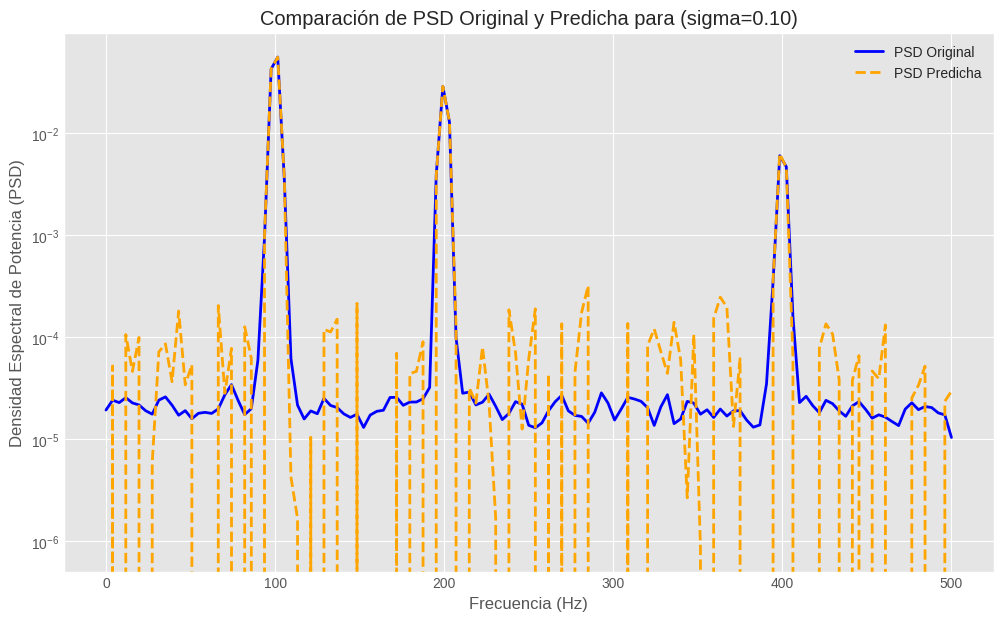

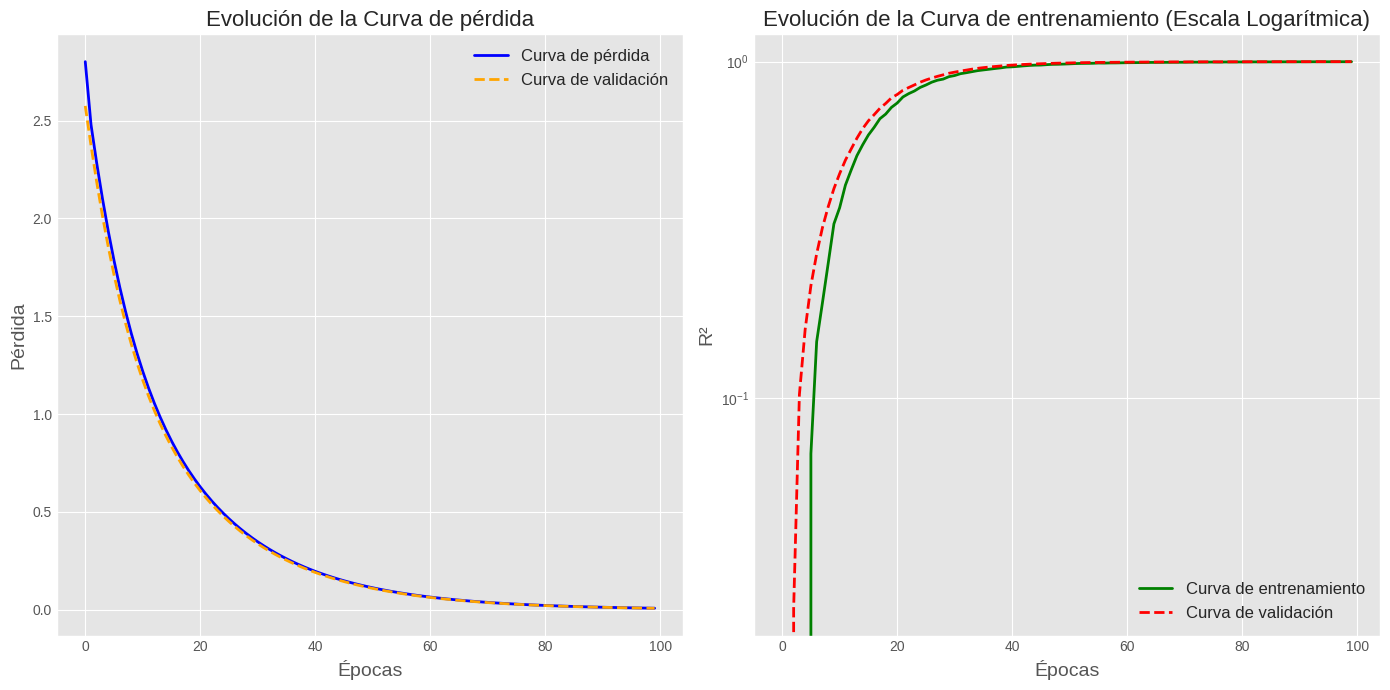

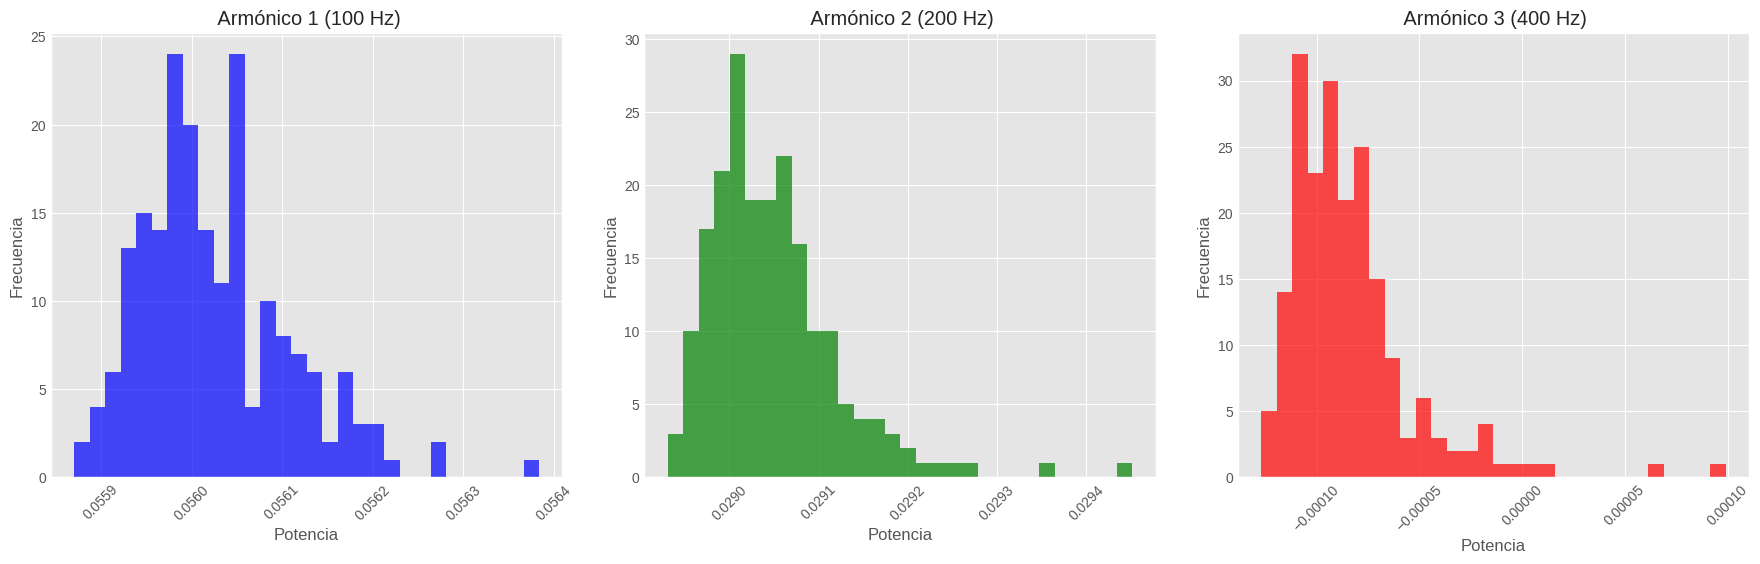

Frecuencia (Hz) y Densidad Espectral de Potencia (V^2/Hz) en los picos detectados:
Frecuencia: 101.56 Hz, Densidad Espectral: 5.618e-02 V^2/Hz
Frecuencia: 199.22 Hz, Densidad Espectral: 2.899e-02 V^2/Hz
Frecuencia: 398.44 Hz, Densidad Espectral: 6.050e-03 V^2/Hz

Resultados del análisis:
Total de frecuencias detectadas: 3
Frecuencias correctas: 3
Frecuencias incorrectas: 0
Porcentaje de error: 0.00%


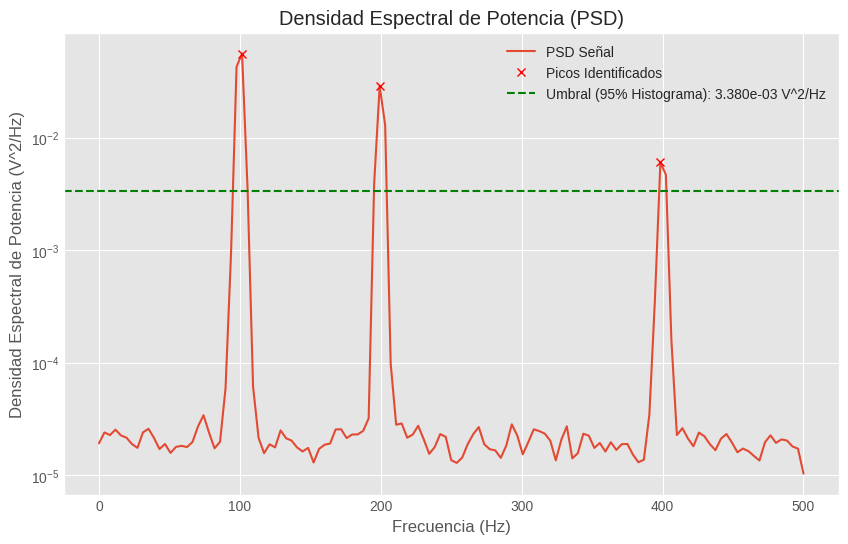

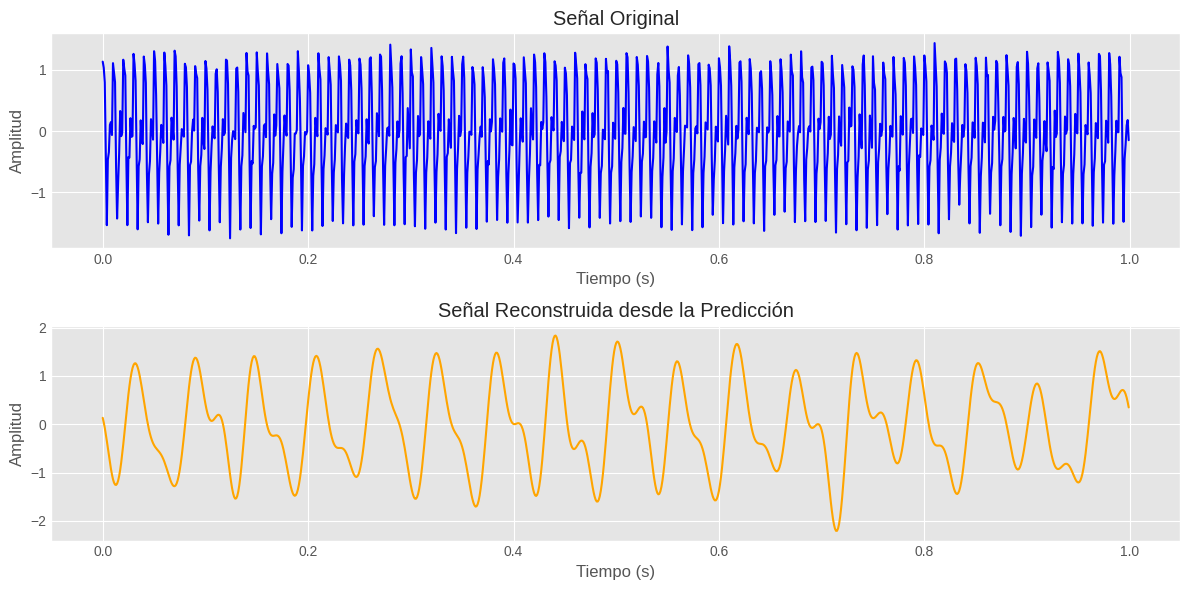

Entrenando modelo con sigma = 0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


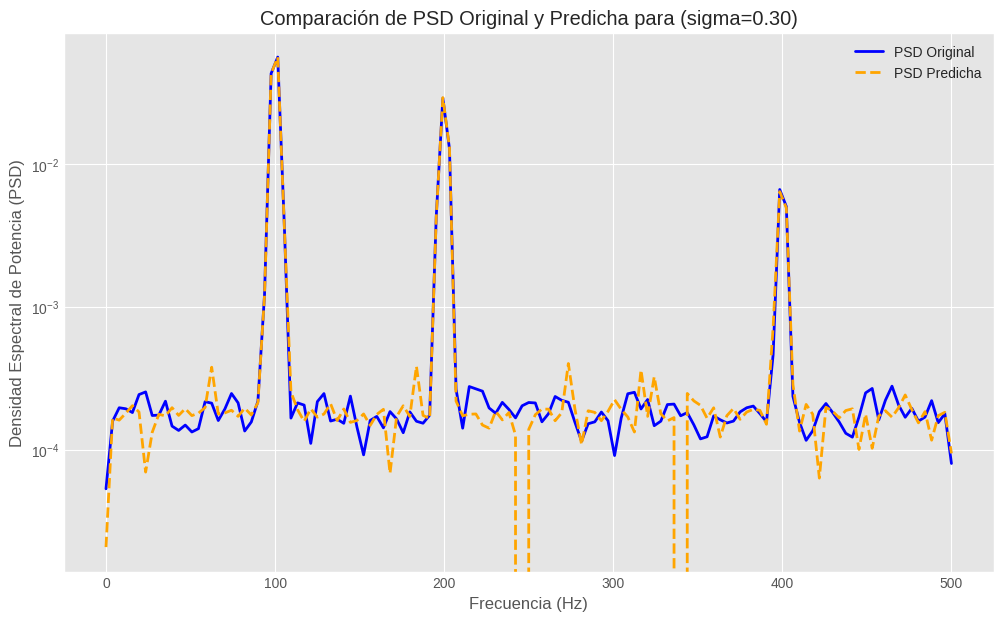

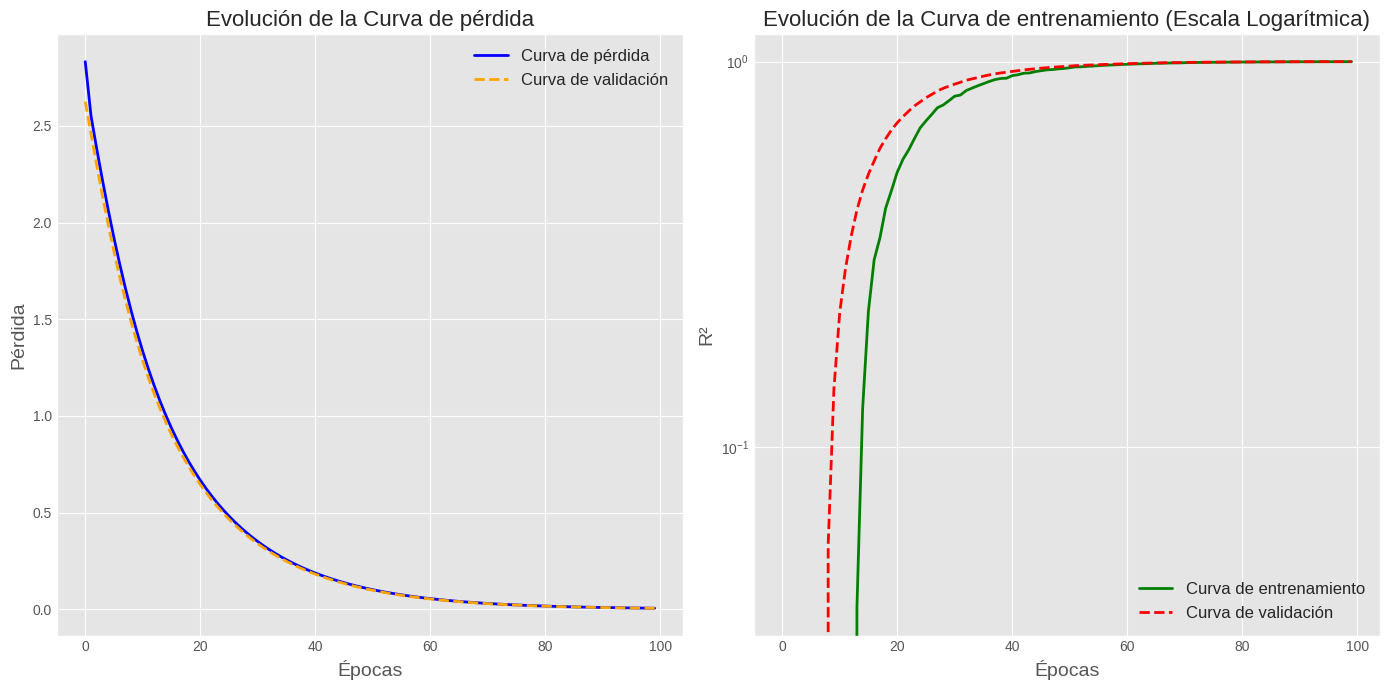

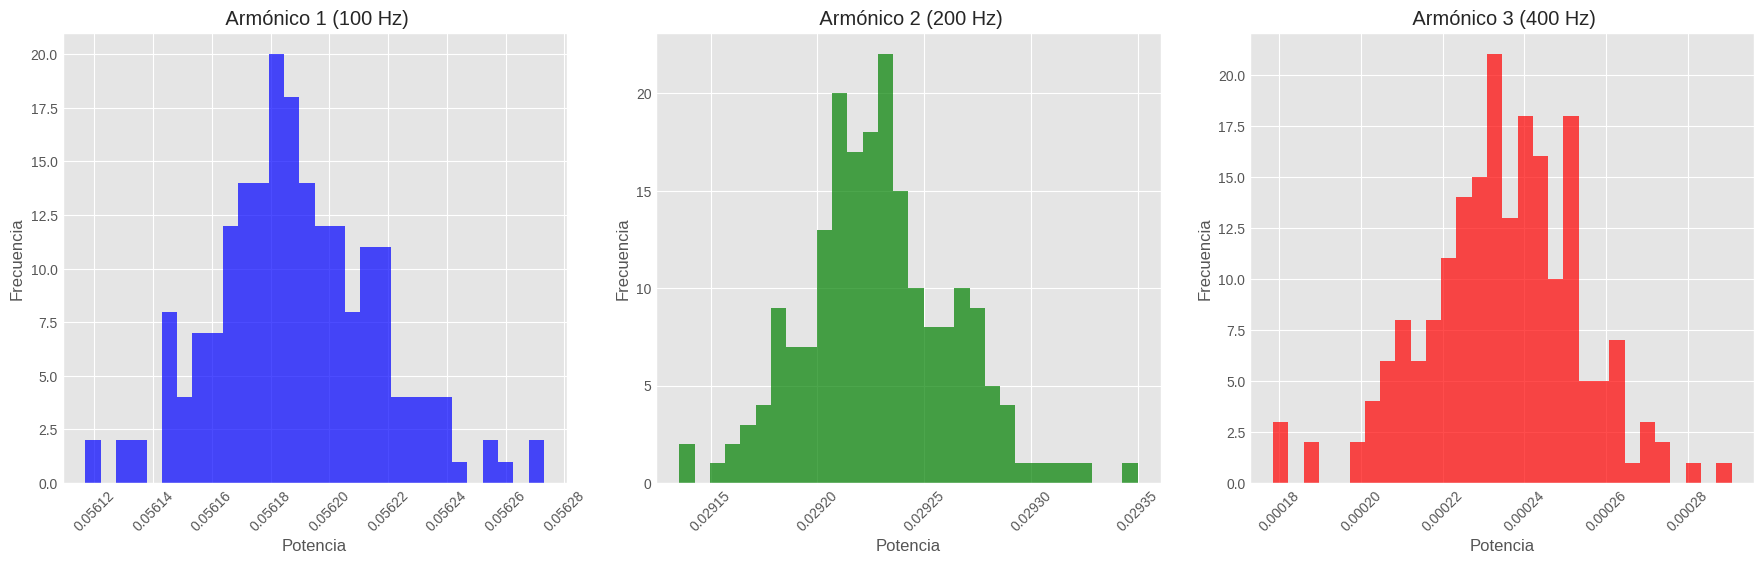

Frecuencia (Hz) y Densidad Espectral de Potencia (V^2/Hz) en los picos detectados:
Frecuencia: 101.56 Hz, Densidad Espectral: 5.631e-02 V^2/Hz
Frecuencia: 199.22 Hz, Densidad Espectral: 2.903e-02 V^2/Hz
Frecuencia: 398.44 Hz, Densidad Espectral: 6.646e-03 V^2/Hz

Resultados del análisis:
Total de frecuencias detectadas: 3
Frecuencias correctas: 3
Frecuencias incorrectas: 0
Porcentaje de error: 0.00%


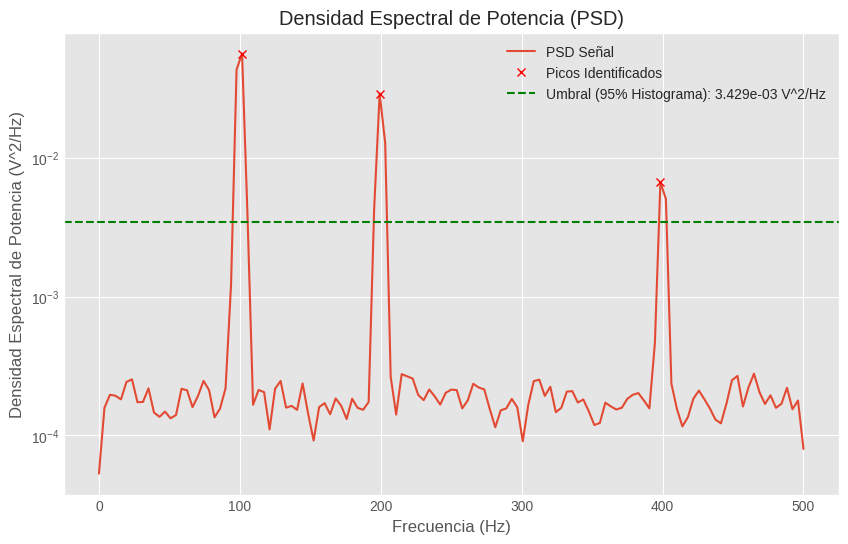

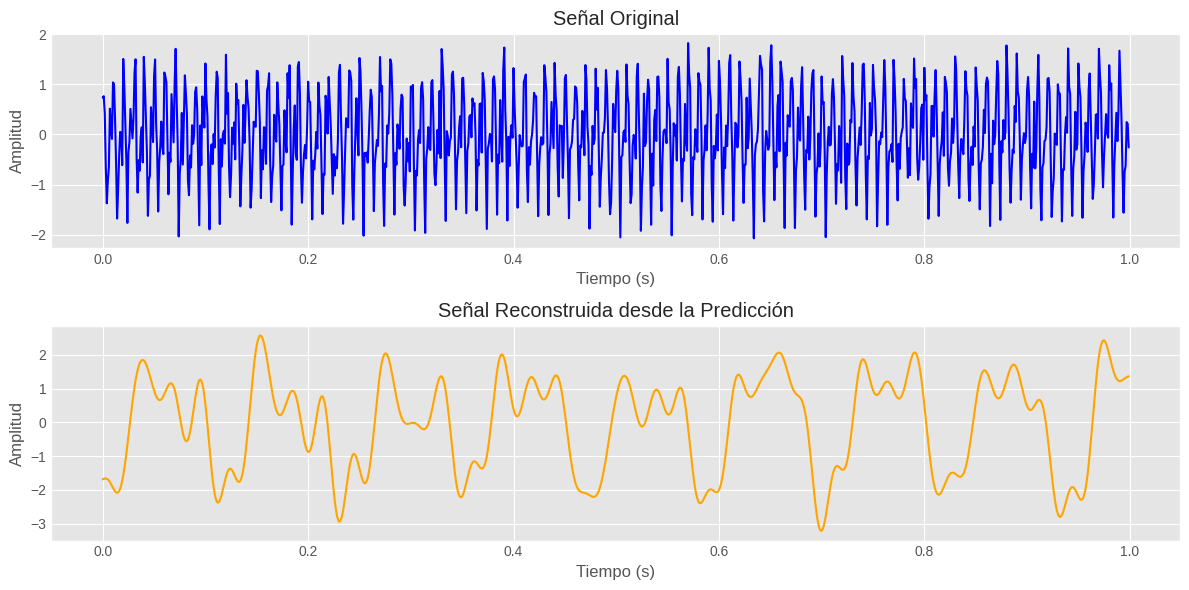

Entrenando modelo con sigma = 1


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


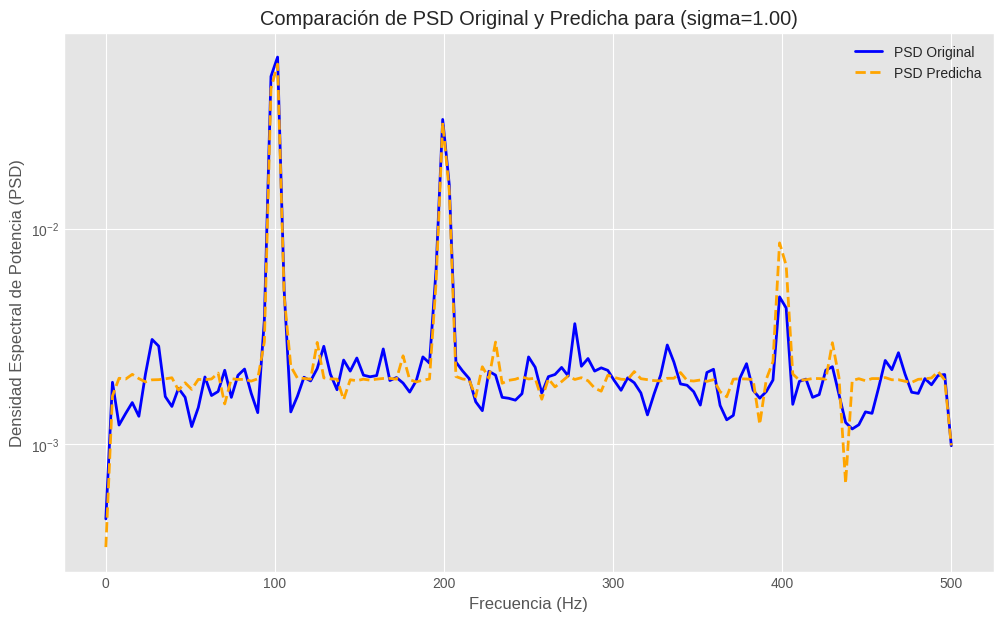

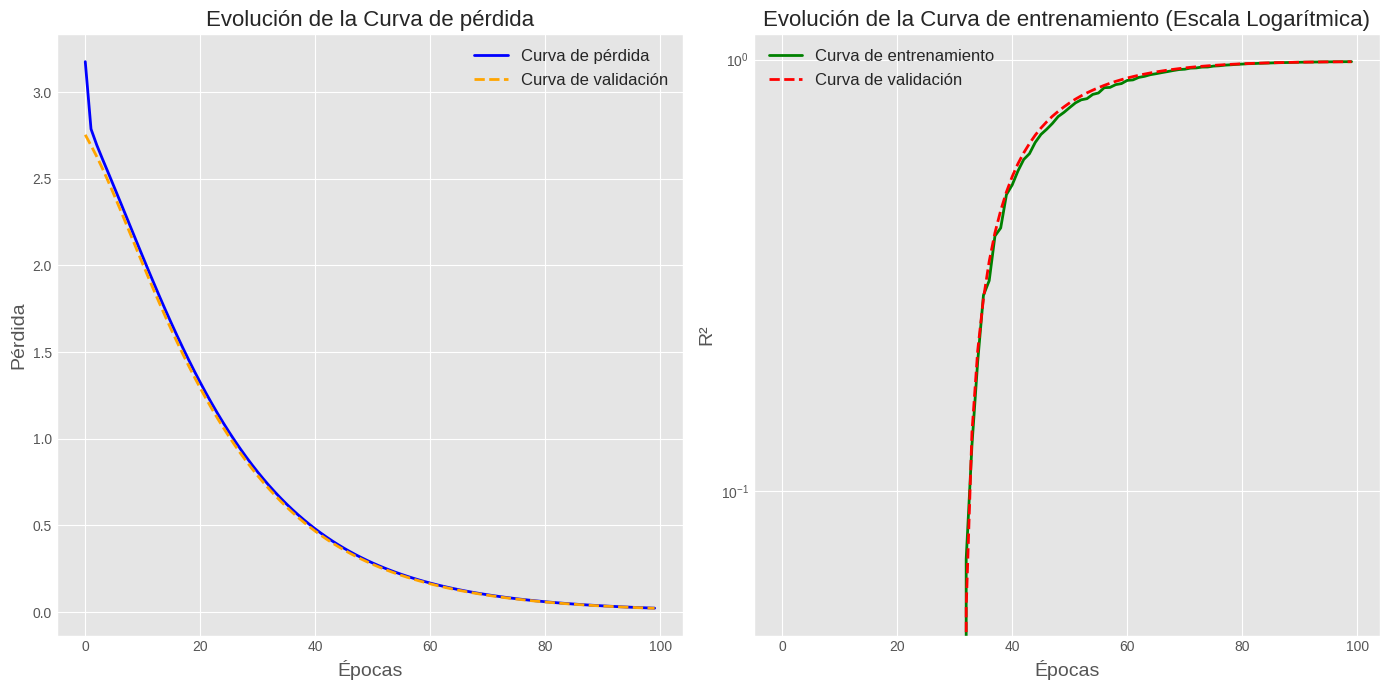

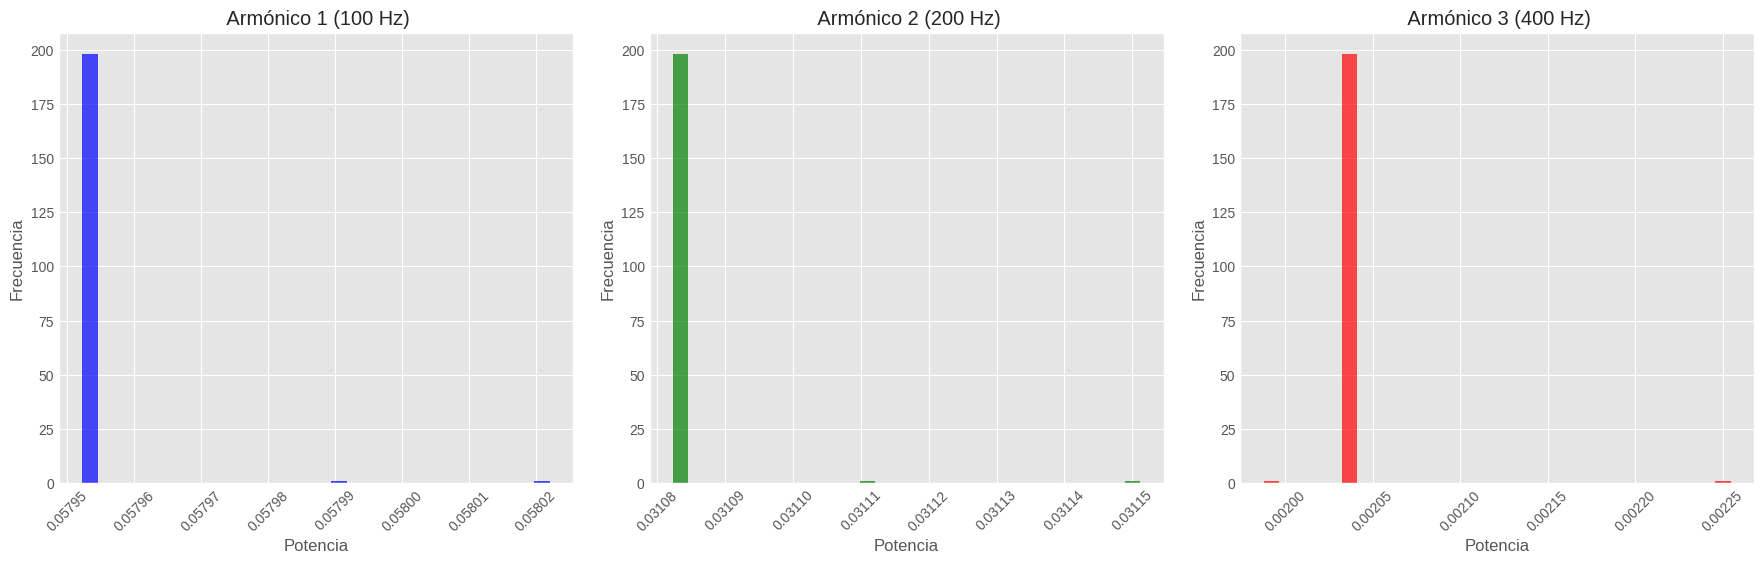

Frecuencia (Hz) y Densidad Espectral de Potencia (V^2/Hz) en los picos detectados:
Frecuencia: 101.56 Hz, Densidad Espectral: 6.245e-02 V^2/Hz
Frecuencia: 199.22 Hz, Densidad Espectral: 3.209e-02 V^2/Hz
Frecuencia: 398.44 Hz, Densidad Espectral: 4.824e-03 V^2/Hz

Resultados del análisis:
Total de frecuencias detectadas: 3
Frecuencias correctas: 3
Frecuencias incorrectas: 0
Porcentaje de error: 0.00%


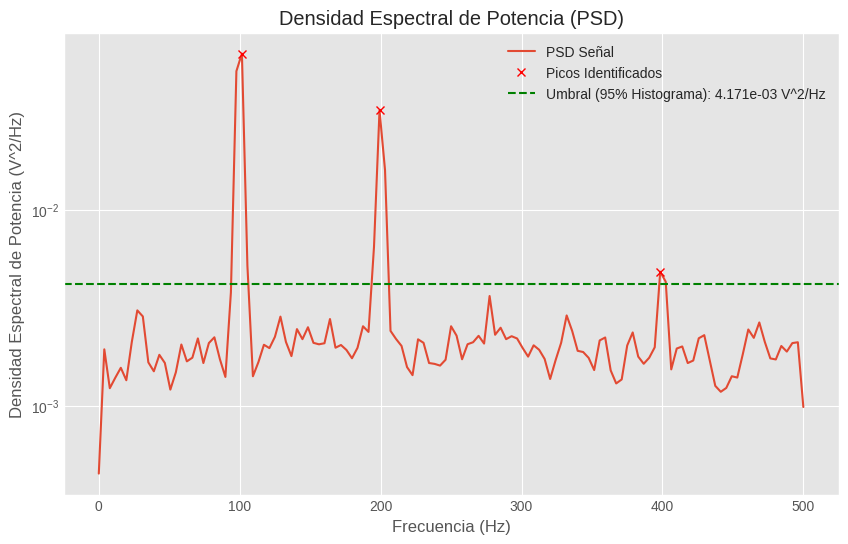

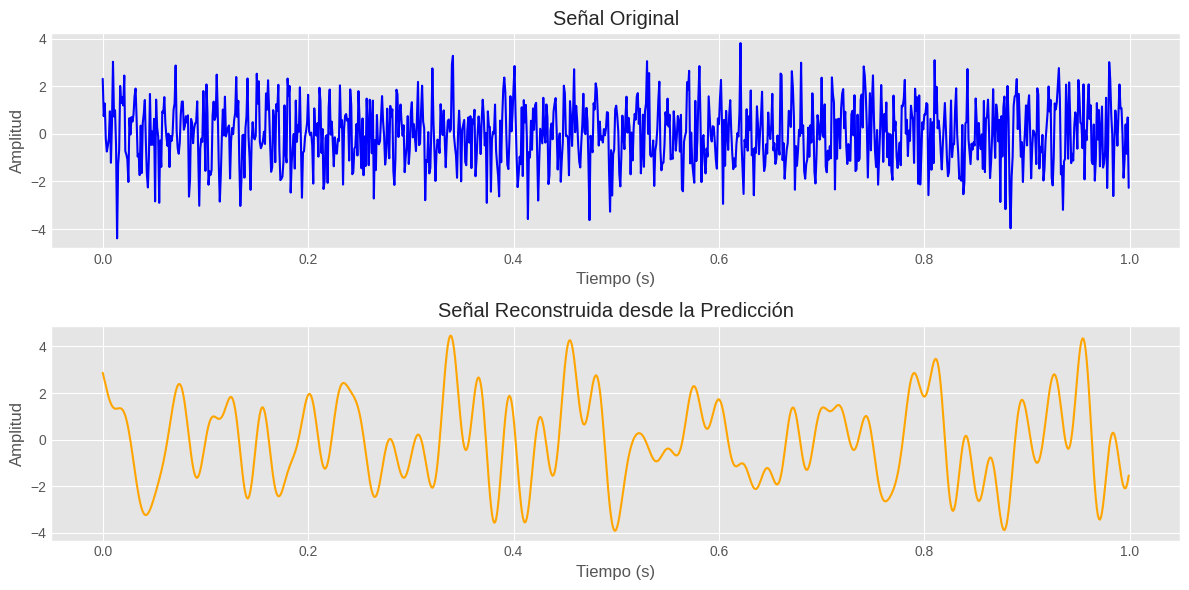

Entrenando modelo con sigma = 3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


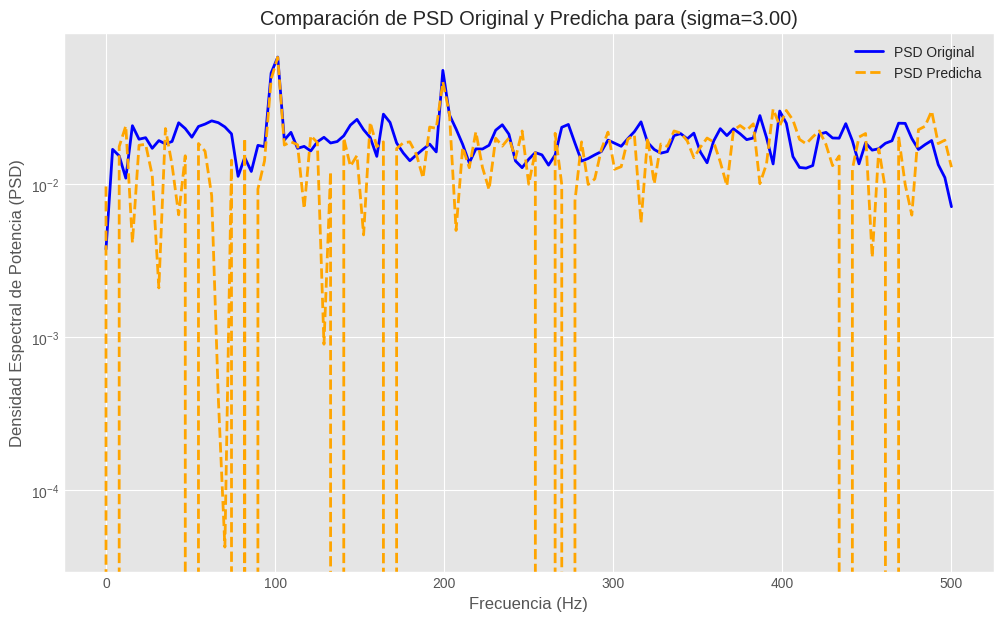

<ipython-input-9-88f2aaf20f01>:95: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


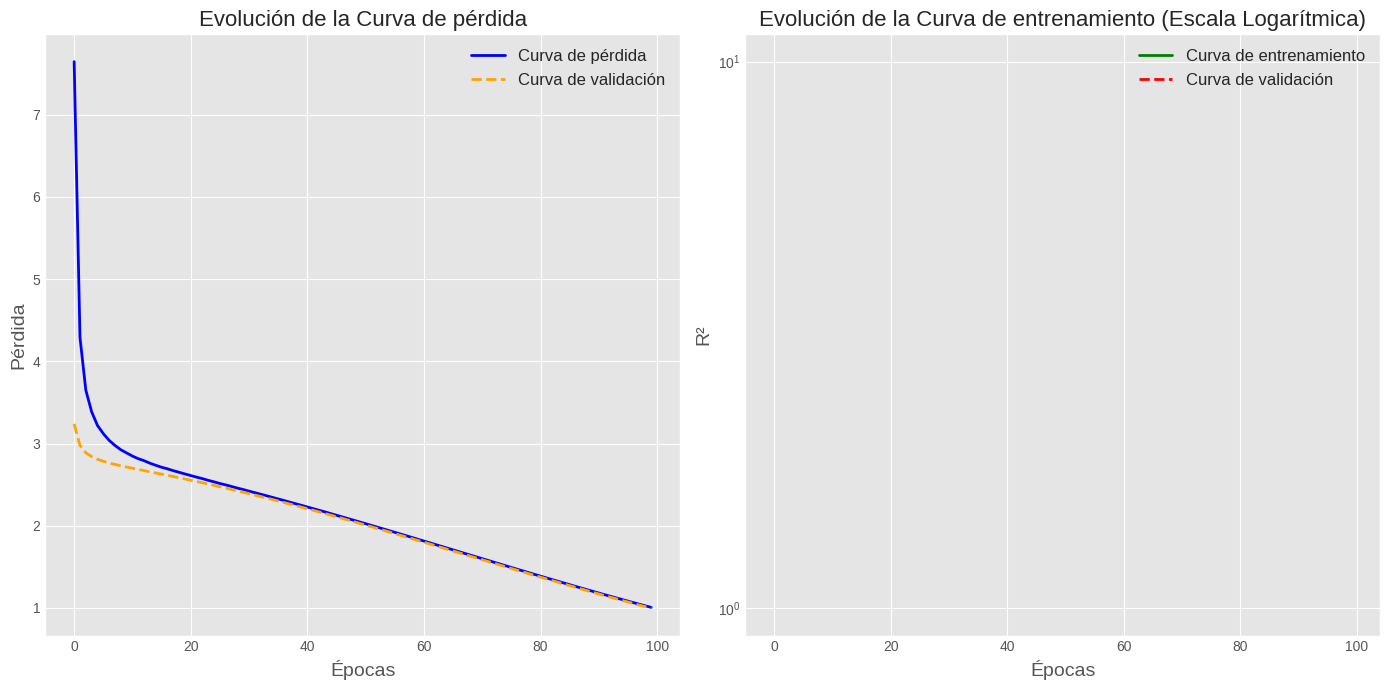

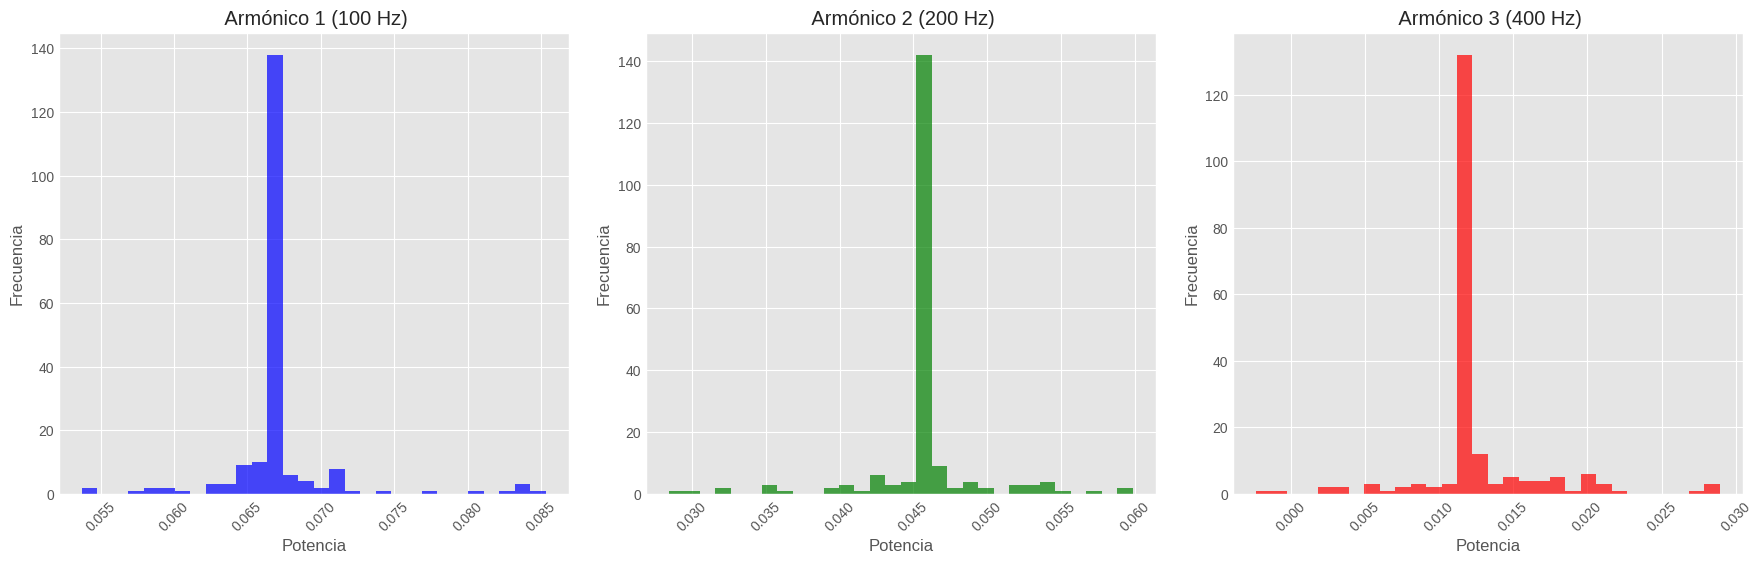

Frecuencia (Hz) y Densidad Espectral de Potencia (V^2/Hz) en los picos detectados:
Frecuencia: 101.56 Hz, Densidad Espectral: 6.779e-02 V^2/Hz
Frecuencia: 164.06 Hz, Densidad Espectral: 2.873e-02 V^2/Hz
Frecuencia: 199.22 Hz, Densidad Espectral: 5.552e-02 V^2/Hz
Frecuencia: 386.72 Hz, Densidad Espectral: 2.811e-02 V^2/Hz
Frecuencia: 398.44 Hz, Densidad Espectral: 3.010e-02 V^2/Hz

Resultados del análisis:
Total de frecuencias detectadas: 5
Frecuencias correctas: 3
Frecuencias incorrectas: 2
Porcentaje de error: 40.00%


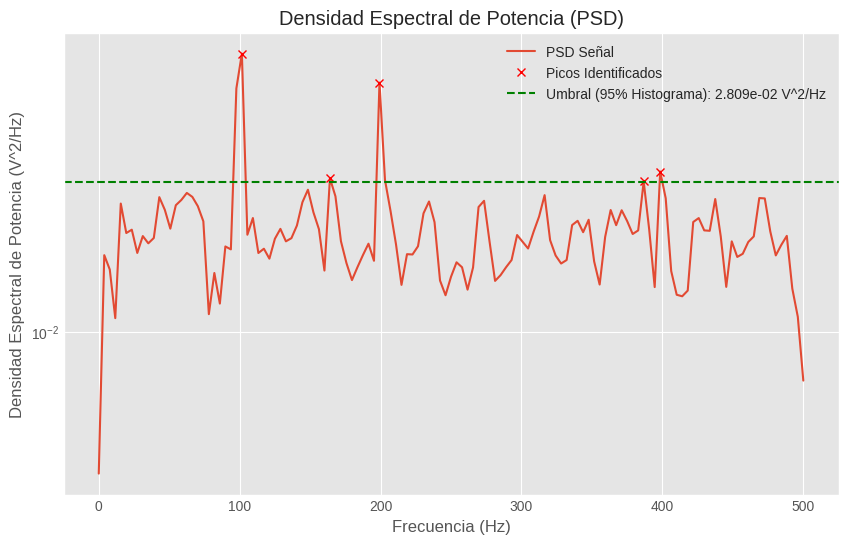

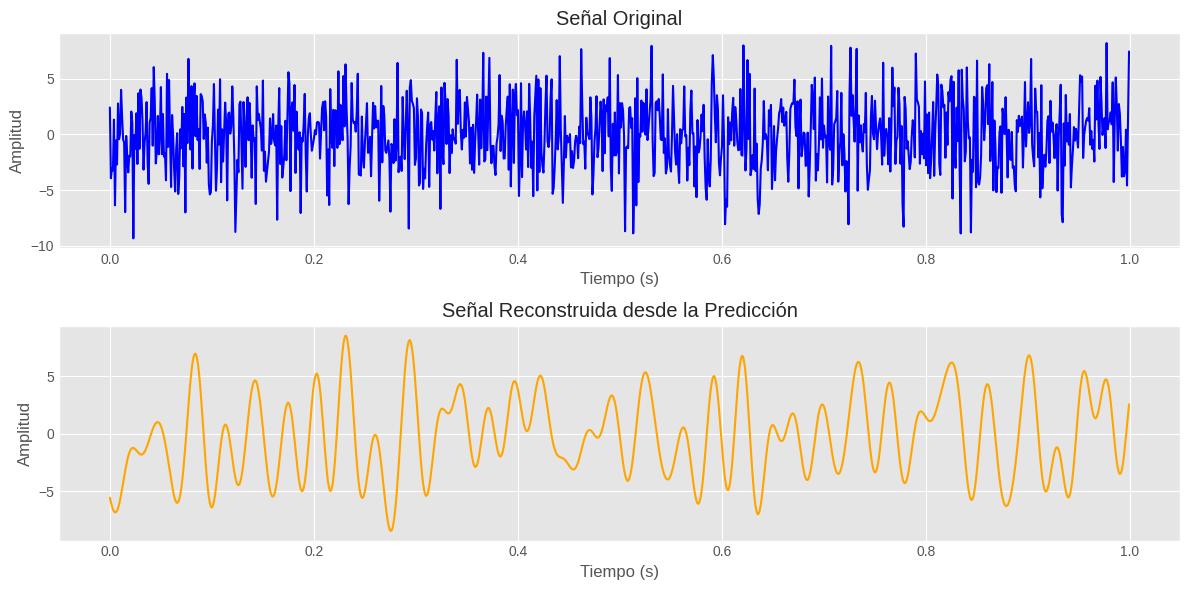

Entrenando modelo con sigma = 10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


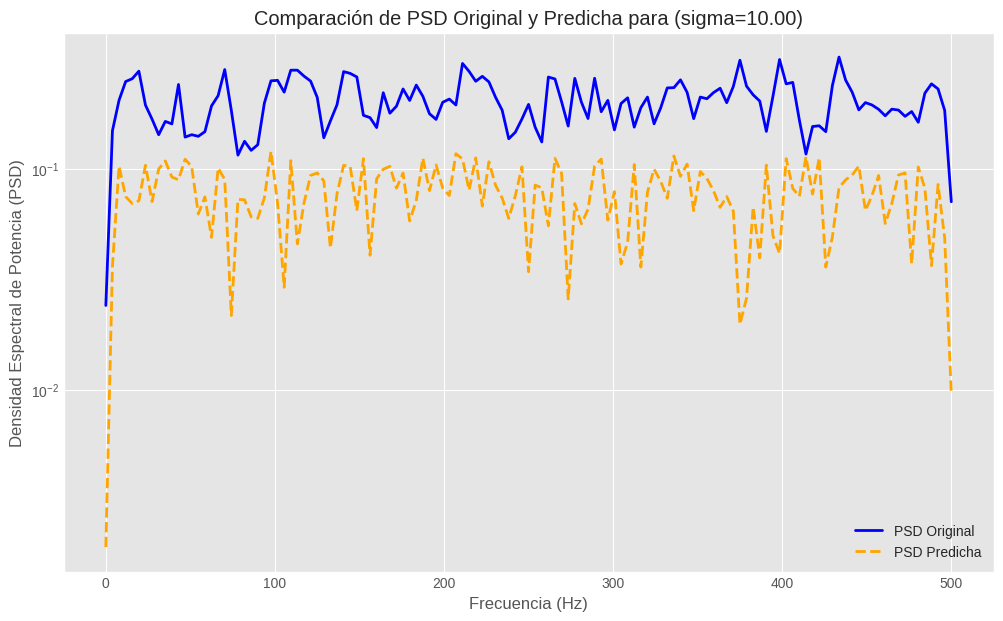

<ipython-input-9-88f2aaf20f01>:95: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


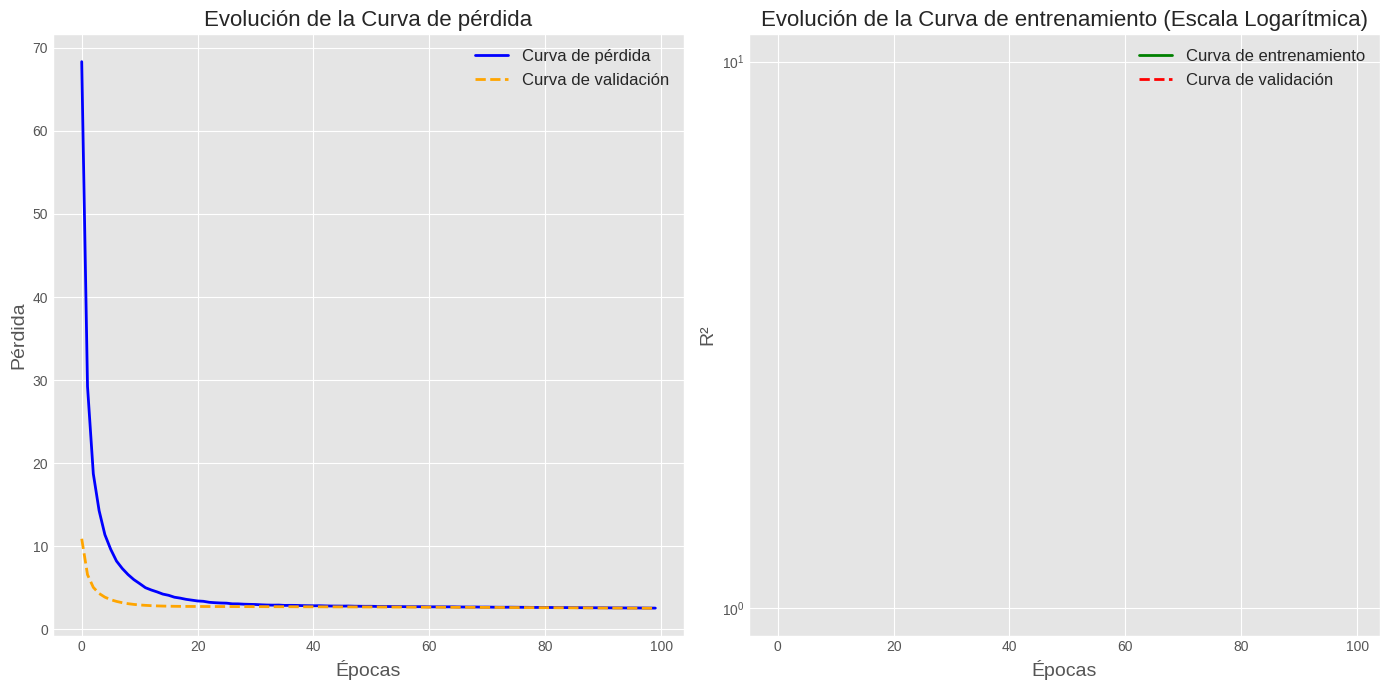

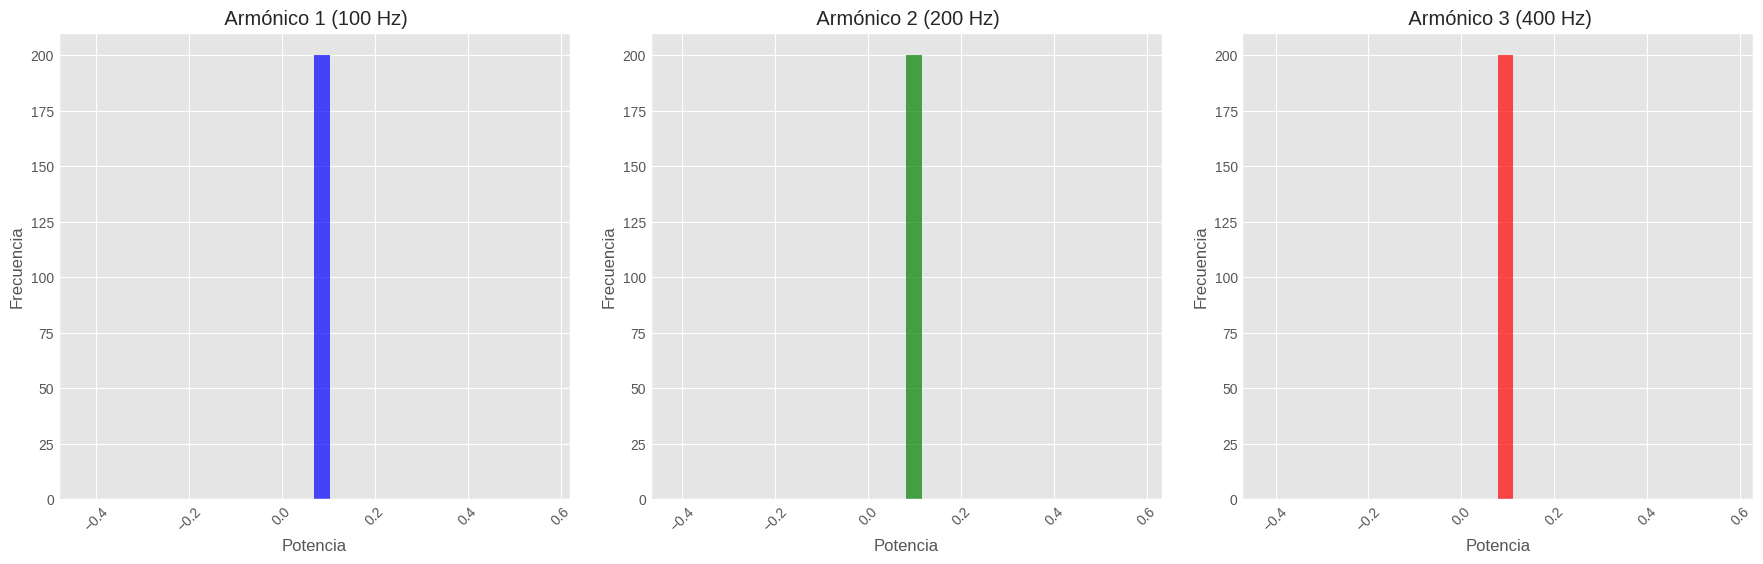

Frecuencia (Hz) y Densidad Espectral de Potencia (V^2/Hz) en los picos detectados:
Frecuencia: 70.31 Hz, Densidad Espectral: 2.806e-01 V^2/Hz
Frecuencia: 113.28 Hz, Densidad Espectral: 2.788e-01 V^2/Hz
Frecuencia: 210.94 Hz, Densidad Espectral: 2.990e-01 V^2/Hz
Frecuencia: 375.00 Hz, Densidad Espectral: 3.092e-01 V^2/Hz
Frecuencia: 398.44 Hz, Densidad Espectral: 3.115e-01 V^2/Hz
Frecuencia: 433.59 Hz, Densidad Espectral: 3.195e-01 V^2/Hz

Resultados del análisis:
Total de frecuencias detectadas: 6
Frecuencias correctas: 1
Frecuencias incorrectas: 5
Porcentaje de error: 83.33%


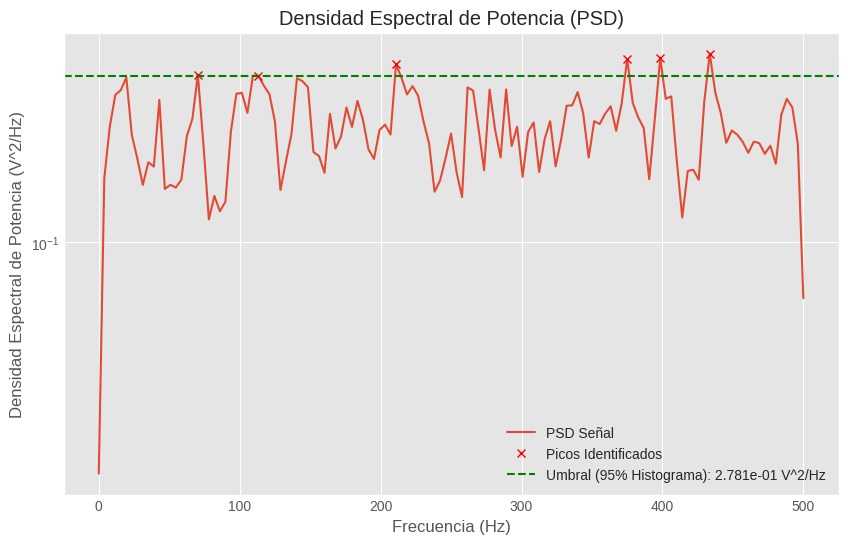

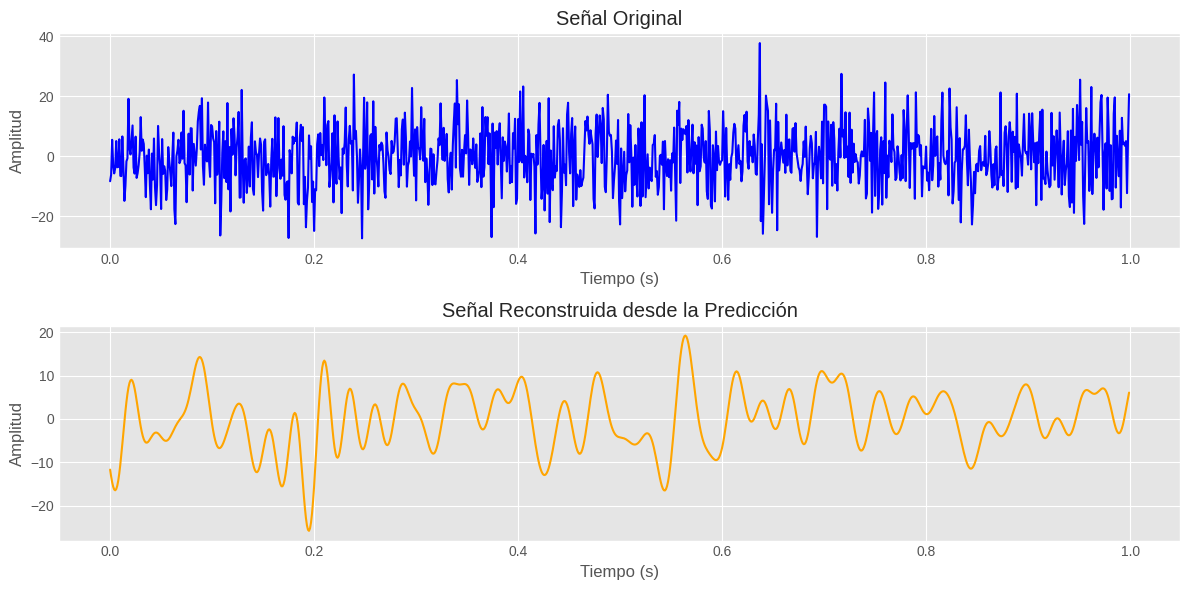

Entrenando modelo con sigma = 30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


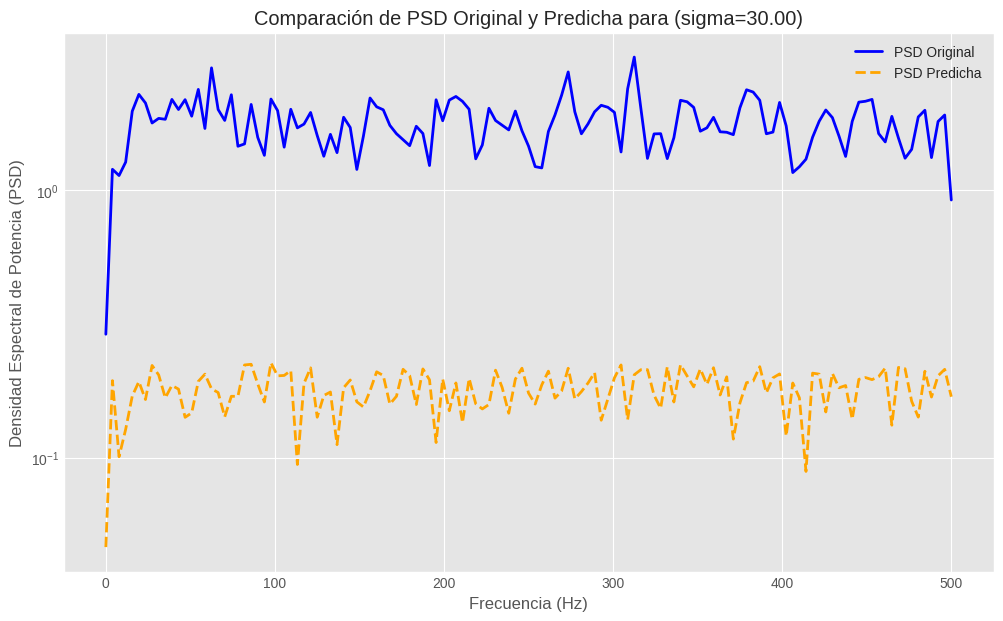

<ipython-input-9-88f2aaf20f01>:95: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


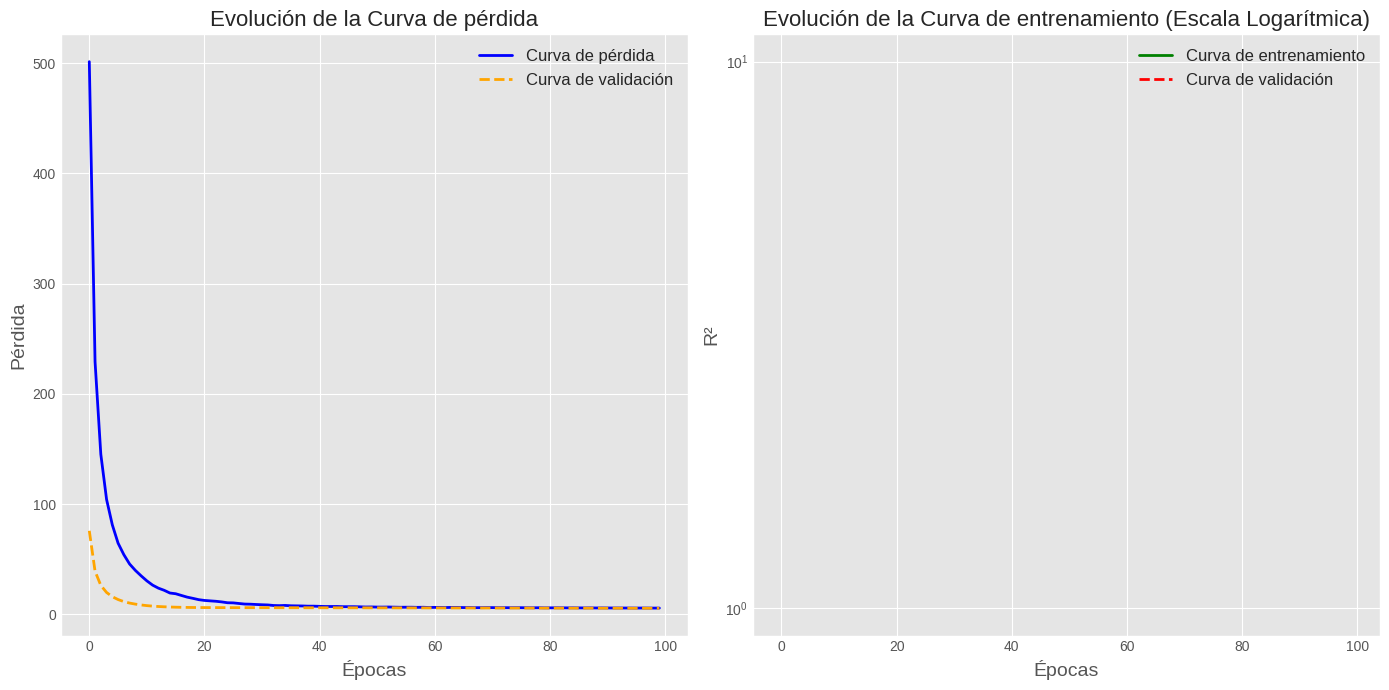

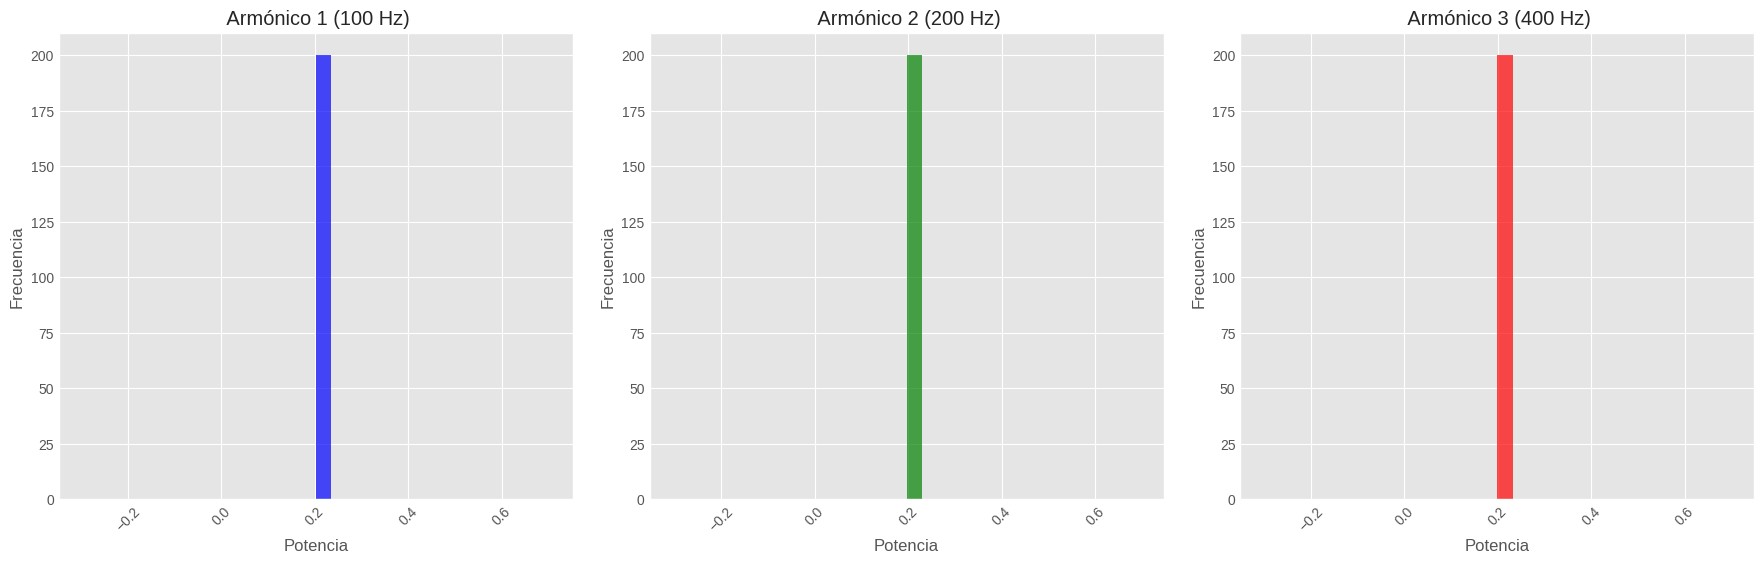

Frecuencia (Hz) y Densidad Espectral de Potencia (V^2/Hz) en los picos detectados:
Frecuencia: 54.69 Hz, Densidad Espectral: 2.391e+00 V^2/Hz
Frecuencia: 62.50 Hz, Densidad Espectral: 2.879e+00 V^2/Hz
Frecuencia: 273.44 Hz, Densidad Espectral: 2.779e+00 V^2/Hz
Frecuencia: 312.50 Hz, Densidad Espectral: 3.159e+00 V^2/Hz
Frecuencia: 378.91 Hz, Densidad Espectral: 2.384e+00 V^2/Hz

Resultados del análisis:
Total de frecuencias detectadas: 5
Frecuencias correctas: 0
Frecuencias incorrectas: 5
Porcentaje de error: 100.00%


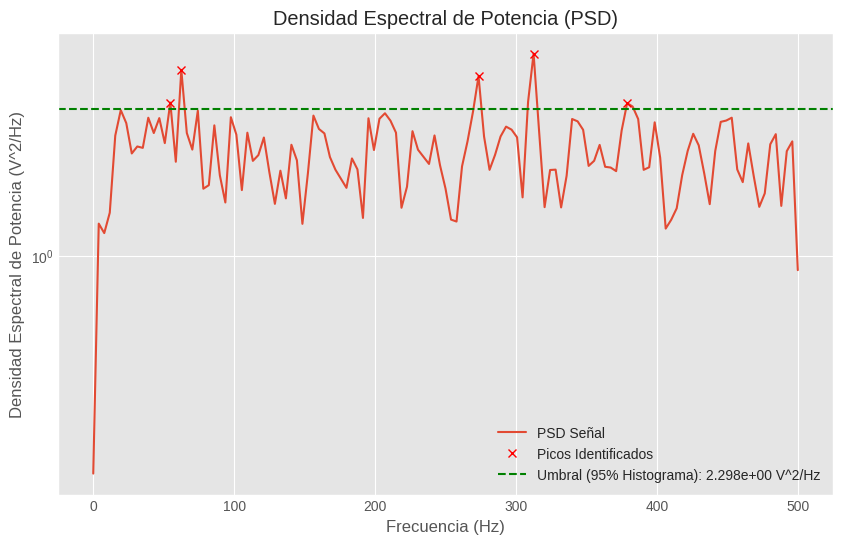

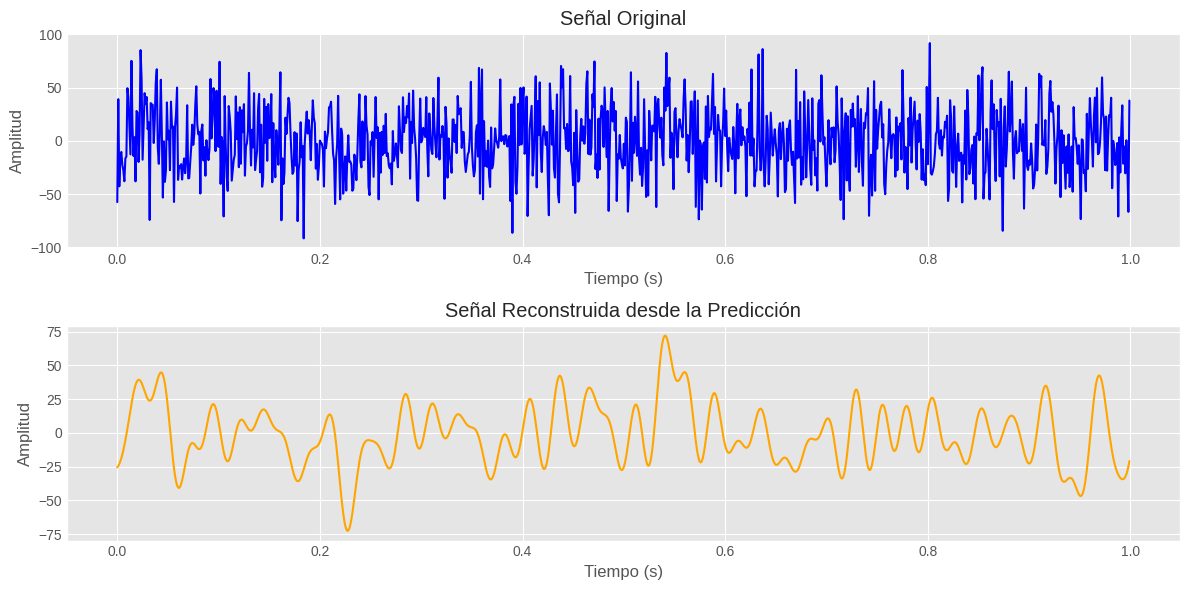

Modelo LSTM
Entrenando modelo con sigma = 0.1


NameError: name 'LSTM' is not defined

In [ ]:
# Parámetros de la señal
fs = 1000  # Frecuencia de muestreo
# Parámetros de las ondas senoidales
f1, f2, f3 = 100, 200, 400
A1, A2, A3 = 0.9, 0.6, 0.3
t = np.linspace(0, 3, fs * 3, endpoint=False)  # Vector de tiempo ajustado para 3 segundos

# Generar la señal
signal = señal_generada(fs, f1, f2, f3, A1, A2, A3, t)

# Lista de diferentes niveles de sigma para el ruido
sigma_values = [0.1, 0.3, 1, 3, 10, 30]
#sigma_values = [0.1]
# Inicializar lista para guardar los resultados
resultados = []
errores = []

for n in range(1,3):
  if n == 1:
    print("Modelo MLP")
  elif n == 2:
    print("Modelo LSTM")
  for sigma in sigma_values:
      print(f"Entrenando modelo con sigma = {sigma}")

      X, y = datos(signal)

      # Dividir los datos en conjuntos de entrenamiento y prueba
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

      # Definir el modelo
      model = Modelos(n, X, y)

      # Compilar el modelo
      model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=[r2_keras])

      # Entrenar el modelo con early stopping
      early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

      history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, verbose=0, callbacks=[early_stopping])
      # Reconstruir señales
      reconstructed_signal_train = model.predict(X_train)
      reconstructed_signal_test = model.predict(X_test)

      calculo_metricas_error(resultados, sigma, y_train, y_test, reconstructed_signal_test, reconstructed_signal_train)

      # Calcular la PSD original para una señal de prueba
      f_original, Pxx_original = welch(X_test[0], fs, nperseg=256)

      y_pred = model.predict(X_test)

      # Obtener predicciones
      y_pred_test = model.predict(X_test)

      comparacion(y_pred, f_original, Pxx_original, sigma)
      grafica_perdida(history)
      histograma_arm(100,200,300,f_original,y_pred)
      umbral()
      señal_reconstruida(X_test, y_pred, t, fs)

# Convertir los resultados a un DataFrame
df_resultados = pd.DataFrame(resultados)
df_errores = pd.DataFrame(errores)
# Mostrar la tabla de errores
print(df_resultados)
metricas_de_error()
print(df_errores)
graficar_error_porcentual(df_errores)
